In [77]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

#Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("darkgrid")

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import collections


from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
pd.set_option("display.max_columns", 999)
pd.get_option("display.max_columns")

pd.set_option("display.max_rows", 999)
pd.get_option("display.max_rows")

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("application_train.csv")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.shape

(307511, 122)

In [4]:
#Check for categoical columns with numbers before one hot encoding
categorical_columns=(df[df.columns].nunique()<10) & (df[df.columns].nunique()>2)
categorical_columns=pd.DataFrame(categorical_columns)

In [5]:
categorical_columns['Datatype']=(df.dtypes!='object')
categorical_columns.columns=['Unique<10','Not object']
categorical_columns.head()

,Unique<10,Not object
SK_ID_CURR,False,True
TARGET,False,True
NAME_CONTRACT_TYPE,False,False
CODE_GENDER,True,False
FLAG_OWN_CAR,False,False


In [6]:
categorical_columns[(categorical_columns['Unique<10']==True) & (categorical_columns['Not object']==True)].index

Index(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK'],
      dtype='object')

**Exploratory Data Analysis and Data Cleaning**

In [7]:
# Imbalanced Class Data - About 8% of the train set are observations that defaulted on their loans
df.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [8]:
# checking data types
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
df.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

Let's try to see the patterns in missing fields

In [10]:
# Checking the days_employed predictor
df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [11]:
# 307511 days is more than 1000 years, replacing it with nulls
df['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

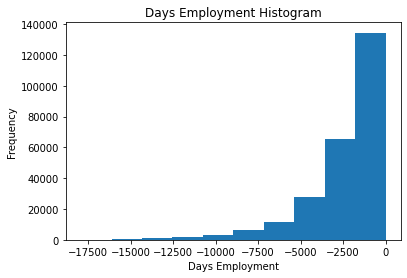

In [12]:
#Checking the distribution of days of employment
df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [13]:
# data is skewed, replacing the nulls with the median
df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].median())

<AxesSubplot:>

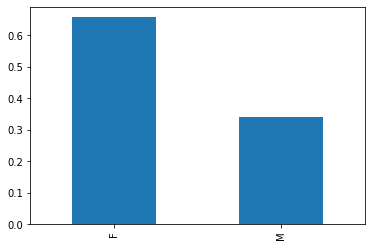

In [14]:
# Checking impact of gender on target variable
((df[df['CODE_GENDER']!='XNA']['CODE_GENDER'].value_counts())/len(df)).plot(kind='bar')

<AxesSubplot:>

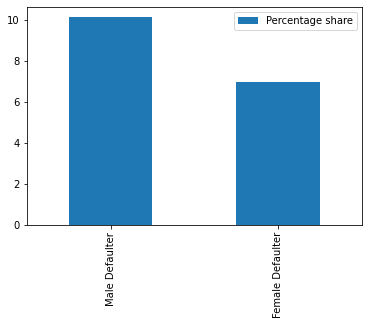

In [15]:
# Male tends to default more
lst=[]

lst.append(len(df[(df['CODE_GENDER']=='M') & (df['TARGET']==1)])*1.0/(len(df[df['CODE_GENDER']=='M'])))
lst.append(len(df[(df['CODE_GENDER']=='F') & (df['TARGET']==1)])*1.0/(len(df[df['CODE_GENDER']=='F'])))

names=['Male Defaulter','Female Defaulter']

gender_default=pd.DataFrame(lst,names)
gender_default=gender_default*100
gender_default.columns=['Percentage share']
gender_default.plot(kind='bar')

<AxesSubplot:>

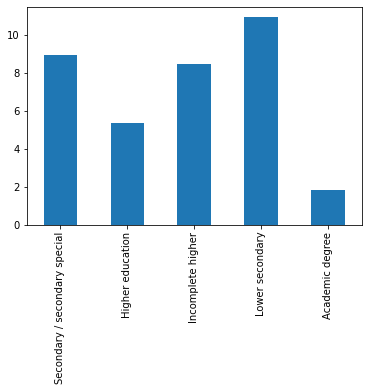

In [16]:
# Checking the impact of education level on target variable - education seems to be inversely proportional to loan default

((df[df['TARGET']==1]['NAME_EDUCATION_TYPE'].value_counts())*100/(df['NAME_EDUCATION_TYPE'].value_counts())).plot(kind='bar')

<AxesSubplot:>

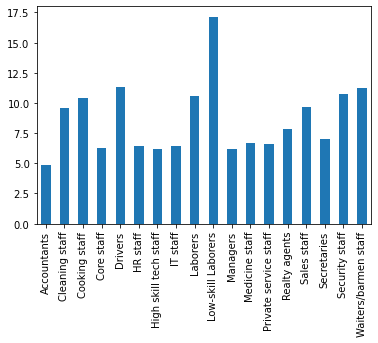

In [17]:
# Low skilled employees tend to do more default

((df[df['TARGET']==1]['OCCUPATION_TYPE'].value_counts())*100/(df['OCCUPATION_TYPE'].value_counts())).plot(kind='bar')

In [18]:
#Checking the distribution of other variables in the dataset
df.AMT_REQ_CREDIT_BUREAU_HOUR.value_counts()

0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

In [19]:
df.AMT_REQ_CREDIT_BUREAU_DAY.value_counts()

0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

In [20]:
df.AMT_REQ_CREDIT_BUREAU_MON.value_counts()

0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
27.0         1
22.0         1
23.0         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

In [21]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.value_counts()

0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

In [22]:
df.AMT_REQ_CREDIT_BUREAU_QRT.value_counts()

0.0      215417
1.0       33862
2.0       14412
3.0        1717
4.0         476
5.0          64
6.0          28
7.0           7
8.0           7
19.0          1
261.0         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

In [23]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.value_counts()

0.0     71801
1.0     63405
2.0     50192
3.0     33628
4.0     20714
5.0     12052
6.0      6967
7.0      3869
8.0      2127
9.0      1096
11.0       31
12.0       30
10.0       22
13.0       19
14.0       10
17.0        7
15.0        6
19.0        4
18.0        4
16.0        3
21.0        1
23.0        1
25.0        1
20.0        1
22.0        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

In [24]:
# Except the year, 0 looks the most common value in all other Credit Bureau enquiry fields
df.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(0, inplace=True)
df.AMT_REQ_CREDIT_BUREAU_DAY.fillna(0, inplace=True)
df.AMT_REQ_CREDIT_BUREAU_MON.fillna(0, inplace=True)
df.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(0, inplace=True)
df.AMT_REQ_CREDIT_BUREAU_QRT.fillna(0, inplace=True)

In [25]:
# Let's explore EXT_SOURCE_3 
df['EXT_SOURCE_3'].value_counts().head(15)

0.746300    1460
0.713631    1315
0.694093    1276
0.670652    1191
0.652897    1154
0.581484    1141
0.689479    1138
0.595456    1136
0.554947    1132
0.621226    1109
0.657784    1092
0.607557    1067
0.643026    1066
0.450747    1064
0.626304    1054
Name: EXT_SOURCE_3, dtype: int64

In [26]:
df['EXT_SOURCE_3'].describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

In [27]:
df.EXT_SOURCE_3.corr(df.EXT_SOURCE_2)

0.10916729237112612

In [28]:
# weak correlation with other external sources (EXT_SOURCE_1 and EXT_SOURCE_2)
df.EXT_SOURCE_3.corr(df.EXT_SOURCE_1)

0.1868455077003878

In [29]:
# couldn't find any specific pattern, replacing with median
df.EXT_SOURCE_3.fillna(df.EXT_SOURCE_3.median(),inplace = True)

In [30]:
# Occupation Type
df.OCCUPATION_TYPE.value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [31]:
# checking if salary is a good indicator for OCCUPATION_TYPE - all the salaries are very close, can't get any inference out of it
df.groupby(df.OCCUPATION_TYPE).describe()['AMT_INCOME_TOTAL']

,count,mean,std,min,25%,50%,75%,max
OCCUPATION_TYPE,,,,,,,,
Accountants,9813.0,194578.357842,108876.812807,27000.0,130500.0,178650.0,225000.0,2214117.0
Cleaning staff,4653.0,130790.895551,64075.793833,25650.0,90000.0,112500.0,157500.0,1080000.0
Cooking staff,5946.0,138396.508176,62742.083077,27000.0,90000.0,126000.0,171000.0,540000.0
Core staff,27570.0,172656.695254,98147.105697,27000.0,112500.0,157500.0,202500.0,3600000.0
Drivers,18603.0,187011.606413,82593.382899,27000.0,135000.0,180000.0,225000.0,2475000.0
HR staff,563.0,188916.282416,93155.321259,30600.0,135000.0,158400.0,225000.0,699750.0
High skill tech staff,11380.0,182842.045683,95711.001374,27000.0,112500.0,157500.0,225000.0,1890000.0
IT staff,526.0,213465.601711,142009.791936,45000.0,135000.0,180000.0,247500.0,2025000.0
Laborers,55186.0,166357.482525,504164.664318,27000.0,112500.0,157500.0,202500.0,117000000.0


Imputing the remaining missing values using sklearn's iterative_imputer package(inspired from R's MICE package)

In [32]:
# importing library
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter = 10, random_state = 0)

In [33]:
# categorical columns
df.columns[df.dtypes.values == 'O']

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 286.2+ MB


In [37]:
# we have 5 categorical features with null values
df.isnull().sum().sort_values(ascending = False).iloc[:6]

COMMONAREA_MODE             214865
COMMONAREA_AVG              214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
dtype: int64

Let's impute the remaining values

In [38]:
df = df.fillna(0)

In [39]:
df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
0                    1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [40]:
df.NAME_TYPE_SUITE.fillna('Unaccompanied', inplace=True)

In [41]:
df['HOUSETYPE_MODE'].value_counts()

0                   154297
block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [42]:
df.HOUSETYPE_MODE.fillna('block of flats', inplace=True)

In [43]:
df['EMERGENCYSTATE_MODE'].value_counts()

No     159428
0      145755
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [44]:
df.EMERGENCYSTATE_MODE.fillna('EMERGENCYSTATE_MODE', inplace=True)

In [45]:
df['WALLSMATERIAL_MODE'].value_counts()

0               156341
Panel            66040
Stone, brick     64815
Block             9253
Wooden            5362
Mixed             2296
Monolithic        1779
Others            1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [46]:
df.WALLSMATERIAL_MODE.fillna('Panel', inplace=True)

In [47]:
df['OCCUPATION_TYPE'].value_counts()

0                        96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [48]:
df.OCCUPATION_TYPE.fillna('Laborers', inplace=True)

In [49]:
# no more nulls
df.isnull().any().sum()

0

**Feature Engineering**

In [51]:
#Changing the days value to positive
df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].apply(lambda x: abs(x))
df['DAYS_BIRTH']=df['DAYS_BIRTH'].apply(lambda x: abs(x))

#Converting days to years
df['YEARS_EMPLOYED']=df['DAYS_EMPLOYED'].apply(lambda x: x/365)
df['YEARS_BIRTH']=df['DAYS_BIRTH'].apply(lambda x:x/365)

In [52]:
# Bucketing Family size
df['CNT_FAM_MEMBERS'].value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
0.0          2
20.0         2
16.0         2
12.0         2
14.0         2
15.0         1
13.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [53]:
bins = pd.IntervalIndex.from_tuples([(0,1), (1,2), (2,4), (4,22)])
df['FAMILY SIZE'] = pd.cut(df['CNT_FAM_MEMBERS'],bins)
df['FAMILY SIZE']=df['FAMILY SIZE'].astype('str')

In [54]:
df['FAMILY SIZE']=df['FAMILY SIZE'].replace('(1, 2]','Small')
df['FAMILY SIZE']=df['FAMILY SIZE'].replace('(0, 1]','Single')
df['FAMILY SIZE']=df['FAMILY SIZE'].replace('(2, 4]','Normal')
df['FAMILY SIZE']=df['FAMILY SIZE'].replace('(4, 22]','Big')

<AxesSubplot:>

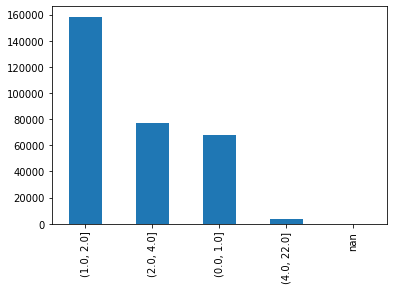

In [56]:
df['FAMILY SIZE'].value_counts().plot(kind='bar')

In [59]:
# bucketing children count
df['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

In [60]:
bins = pd.IntervalIndex.from_tuples([(-1,0), (0,20)])
df['IS_CHILDREN'] = pd.cut(df['CNT_CHILDREN'],bins)
df['IS_CHILDREN']=df['IS_CHILDREN'].astype('str')

In [61]:
df['IS_CHILDREN']=df['IS_CHILDREN'].replace('(-1, 0]','0')
df['IS_CHILDREN']=df['IS_CHILDREN'].replace('(0, 20]','1')

<AxesSubplot:>

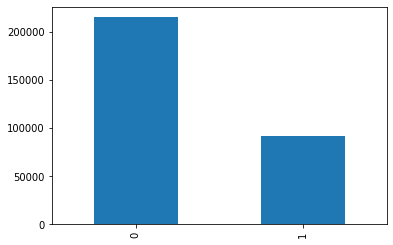

In [63]:
df['IS_CHILDREN'].value_counts().plot(kind='bar')

In [64]:
# credit income ratio
df['credit_income_ratio'] = df.apply(lambda x: x['AMT_CREDIT'] / x['AMT_INCOME_TOTAL'], axis=1)

In [65]:
# annuity income ratio
df['annuity_income_ratio'] = df.apply(lambda x: x['AMT_ANNUITY'] / x['AMT_INCOME_TOTAL'], axis=1)

Split train and test back

In [66]:
df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]=df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].astype('object')

In [67]:
df.shape

(307511, 128)

In [68]:
df_dummy = pd.get_dummies(df)

In [69]:
df_dummy.shape, df.shape

((307511, 267), (307511, 128))

In [70]:
# Feature names
features = list(df_dummy.columns)

In [71]:
df_dummy['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [72]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
# # Scale each feature to 0-1

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range = (0, 1))

# scaler.fit(train_test_merged_dummy)
# train_test_merged_dummy = pd.DataFrame(scaler.transform(train_test_merged_dummy))

# train_test_merged_dummy.columns = features
# train_test_merged_dummy.head()

**##** "train" and "test" are our processed and cleaned data

In [73]:
# y will be target variable
y = df['TARGET'].copy()
y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [75]:
# removing target variable from train, we already have separate target variable field in the above step. Also SK_ID_CURR is just serial number so removing them
train = df.drop(columns = ['TARGET'])
train.shape, train.shape

((307511, 127), (307511, 127))

**Treating Data Imbalance - Oversampling using SMOTE**

In [80]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_EMPLOYED,YEARS_BIRTH,FAMILY SIZE,IS_CHILDREN,credit_income_ratio,annuity_income_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,637.0,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.745205,25.920548,"(0.0, 1.0]",0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,1188.0,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795,45.931507,"(1.0, 2.0]",0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,225.0,-4260.0,-2531,26.0,1,1,1,

In [78]:
#Split the data using train-test split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

In [79]:
## SMOTE - faster but need to encode categorical data
from imblearn.over_sampling import SMOTE
train_resample, y_resample = SMOTE().fit_resample(X_train,y_train)

y_resample = pd.Series(y_resample)
train_resample = pd.DataFrame(train_resample)
train.shape, y.shape, train_resample.shape, y_resample.shape

ValueError: could not convert string to float: 'Cash loans'

In [ ]:
train_resample.columns = train.columns

In [ ]:
train_resample.head()

In [ ]:
y_resample.value_counts()

We will use the resampling output for model building

**Model Building - 2.1 RandomForest without Resampling**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1) #n_jobs = -1 meaning utilize all system resources

In [ ]:
# Fit the model
rf_model = random_forest.fit(train, y)

In [ ]:
# Make predictions on the test data
pred_rf = random_forest.predict_proba(test)[:, 1]

In [ ]:
final_RF_pred = pd.DataFrame(pred_rf)
#final_RF_pred.to_csv('rf_pred.csv')

In [ ]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:20]

In [ ]:
feature_importances[:20].plot(kind='bar')

*Test AUC - 0.698*

**Model Building - 2.2 RandomForest with SMOTE**

In [ ]:
rf_model_resample = random_forest.fit(train_resample, y_resample)
pred_rf_resample = random_forest.predict_proba(test)[:, 1]
final_RF_pred_resample = pd.DataFrame(pred_rf_resample)
final_RF_pred_resample.to_csv('rf_pred_resample.csv')

*Test AUC - 0.691*

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

log_model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',C=0.1).fit(train_scaled, y)
pred_log = log_model.predict_proba(test_scaled)[:,1]

In [ ]:
log_model.coef_

In [ ]:
train.columns

In [ ]:
log_model_features=pd.DataFrame(log_model.coef_[0])
log_model_features.index=train.columns

In [ ]:
log_model_features.columns=['Importance Score']
log_model_features.sort_values(by='Importance Score',ascending=False)[:20]

**Model Building - 3.1. XGBoost without resampling**

Without tuning

In [ ]:
import xgboost as xgb

In [ ]:
params = {
   
    'max_depth': 7, # to control over-fitting, optimal value range: 3-10
    'gamma' :0, # the minimum loss reduction required to make a split, XGB will build the tree first then prune in case of 0 gamma
    'eta':.05, # shrinkage factor, optimal value range: 0.01-0.2
    'subsample': 0.7, # fraction of observations to be randomly samples for each tree, optimal value range: 0.5-1
    'colsample_bytree': 0.7, # fraction of columns to be randomly samples for each tree, optimal value range: 0.5-1
    'scale_pos_weight' : 1.0, # for imbalanced data
    'objective':'binary:logistic', # loss function to be minimized
    'eval_metric':'auc', # metric to be used for validation data
    'silent': 0 # running messages will be printed
}

In [ ]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,
                    num_boost_round=500, # number of boosting rounds or trees to build
                    early_stopping_rounds=10, # stop if performance haven’t improved for N rounds
                    evals=[(matrix_test,'test')]
                   )
    return model

In [ ]:
from sklearn.model_selection import train_test_split
xgb_train, xgb_val, xgb_y_train, xgb_y_val = train_test_split(train, y, test_size = 0.2, random_state = 42)

In [ ]:
xgb_model = XGBmodel(xgb_train,xgb_val,xgb_y_train,xgb_y_val,params)

In [ ]:
xgb_features=pd.DataFrame(xgb_model.get_score(importance_type='gain'), index=[0])
xgb_features

In [ ]:
xgb.plot_importance(xgb_model, max_num_features=20)

**XGBoost Hyperparameter Tuning**

In [ ]:
# cv_results = xgb.cv(
#                     params=params,
#                     dtrain=xgb.DMatrix(xgb_train,label=xgb_y_train),
#                     num_boost_round=5000,
#                     early_stopping_rounds=10,
#                     seed=42,
#                     nfold=5,
#                     metrics = 'auc'
#                     )    
# cv_results # returns a table where the rows correspond to the number of boosting trees used

In [ ]:
# cv_results['test-auc-mean'].max()

In [ ]:
# We will first tune our parameters to maximize the test AUC in cross-validation
# then we will check the performance of our model on the validation set

In [ ]:
# Let's start tuning the parameters subsample and colsample_bytree

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,9)]
    for colsample in [i/10. for i in range(6,9)]
]

In [ ]:
# Define initial best params and MAE
max_auc = 0
best_params = None

# Start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample,colsample))
    
    # Update parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    # Run CV
    cv_results = xgb.cv(
                        params=params,
                        dtrain=xgb.DMatrix(xgb_train,label=xgb_y_train),
                        num_boost_round=5000,
                        early_stopping_rounds=10,
                        seed=42,
                        nfold=5,
                        metrics = 'auc'
                        )
    
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

In [ ]:
params['subsample'] = 0.7 #best_params[0]
params['colsample_bytree'] = 0.7 #best_params[1]

In [ ]:
# Tuning shrinkage factor

max_auc = 0
best_params = None

for eta in [.2, .1, .05, .01]:
    print("CV with eta={}".format(eta))
    
    # Update parameters
    params['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(
                        params=params,
                        dtrain=xgb.DMatrix(xgb_train,label=xgb_y_train),
                        num_boost_round=5000,
                        early_stopping_rounds=10,
                        seed=42,
                        nfold=5,
                        metrics = 'auc'
                        )
    
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

In [ ]:
# final tuned parameters
params = {
   
    'max_depth': 7, # to control over-fitting, optimal value range: 3-10
    'gamma' :0, # the minimum loss reduction required to make a split, XGB will build the tree first then prune in case of 0 gamma
    'eta':.03, # shrinkage factor, optimal value range: 0.01-0.2
    'subsample': 0.8, # fraction of observations to be randomly samples for each tree, optimal value range: 0.5-1
    'colsample_bytree': 0.8, # fraction of columns to be randomly samples for each tree, optimal value range: 0.5-1
    'scale_pos_weight' : 11.0, # for imbalanced data
    'objective':'binary:logistic', # loss function to be minimized
    'eval_metric':'auc', # metric to be used for validation data
    'silent': 0 # running messages will be printed
}


In [ ]:
# train final model using tuned parameters
xgb_model = XGBmodel(xgb_train,xgb_val,xgb_y_train,xgb_y_val,params)

In [ ]:
xgb_test = xgb.DMatrix(test)

In [ ]:
pred_xgb = xgb_model.predict(xgb_test, ntree_limit = xgb_model.best_ntree_limit).tolist()
final_xgb_pred = pd.DataFrame(pred_xgb)

In [ ]:
final_xgb_pred.to_csv('XGB.csv')

*Test AUC - 0.74*

**Model Building - 3.1. XGBoost with SMOTE resampling**

In [ ]:
params['scale_pos_weight'] = 1

xgb_train_resample, xgb_val_resample, xgb_y_train_resample, xgb_y_val_resample = train_test_split(train_resample, y_resample, test_size = 0.2, random_state = 42)

xgb_model_resample = XGBmodel(xgb_train_resample,xgb_val_resample,xgb_y_train_resample,xgb_y_val_resample,params)

pred_xgb_resample = xgb_model_resample.predict(xgb_test, ntree_limit = xgb_model_resample.best_ntree_limit).tolist()
final_xgb_pred_resample = pd.DataFrame(pred_xgb_resample)

final_xgb_pred_resample.to_csv('XGB_resample.csv')

*Test AUC - 0.746*

**Model Building - 4.1. LGBM without resampling**

In [ ]:
import lightgbm as lgb

In [ ]:
# lgbm_train = train
# lgbm_test = test

In [ ]:
# lgbm_categ_column = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
#        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
#        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
#        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

In [ ]:
lgbm_train,lgbm_val,lgbm_y_train,lgbm_y_val = train_test_split(train,y, test_size = 0.2, random_state = 42)

In [ ]:
# taking data as LightGBM format
trn_data = lgb.Dataset(lgbm_train, label=lgbm_y_train)
val_data = lgb.Dataset(lgbm_val, label=lgbm_y_val)

In [83]:
lgbm_model = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'dart',
    "max_depth" : 8,
    "sub_sample":0.8,
    "num_leaves" : 31,
    "learning_rate" : 0.01,
    "seed": 42}

In [84]:
fit_lgbm = lgb.train(lgbm_model, trn_data, num_boost_round= 500, valid_sets = [trn_data, val_data], verbose_eval=500, 
                early_stopping_rounds = 100)

NameError: name 'lgb' is not defined

In [ ]:
pred_lgbm = fit_lgbm.predict(test, num_iteration=fit_lgbm.best_iteration)

In [ ]:
lgb.plot_importance(fit_lgbm,max_num_features=20)

In [ ]:
final_lgbm_pred = pd.DataFrame(pred_lgbm)

In [ ]:
final_lgbm_pred.to_csv('lgb.csv')

*Test AUC - 0.743*

**Model Building - 4.2. LGBM with SMOTE resampling**

In [ ]:
lgbm_train_resample,lgbm_val_resample,lgbm_y_train_resample,lgbm_y_val_resample = train_test_split(train_resample, y_resample, test_size = 0.2, random_state = 42)

trn_data_resample = lgb.Dataset(lgbm_train_resample, label=lgbm_y_train_resample)
val_data_resample = lgb.Dataset(lgbm_val_resample, label=lgbm_y_val_resample)

fit_lgbm_resample = lgb.train(lgbm_model, trn_data_resample, num_boost_round= 500, valid_sets = [trn_data_resample, val_data_resample], verbose_eval=500, 
                early_stopping_rounds = 100)

pred_lgbm_resample = fit_lgbm_resample.predict(test, num_iteration=fit_lgbm_resample.best_iteration)
final_lgbm_pred_resample = pd.DataFrame(pred_lgbm_resample)
final_lgbm_pred_resample.to_csv('lgb_resample.csv')

*Test AUC - 0.75*

**Model Building - 5. CATBoost**

In [ ]:
!pip install catboost

import catboost
from catboost import Pool, CatBoostClassifier,cv

In [ ]:
cat_train = train_test_merged[train_test_merged['Train_YN'] == 1].copy()
cat_test = train_test_merged[train_test_merged['Train_YN'] == 0].copy()

cat_test.drop(columns = ['TARGET','Train_YN'], inplace = True)
cat_train.drop(columns = ['Train_YN'], inplace = True)

cat_y = cat_train['TARGET'].copy()

cat_train.drop(columns = ['TARGET'], inplace = True)
cat_train.shape, cat_test.shape, cat_y.shape

In [ ]:
# categorical columns

cat_train.columns[cat_train.dtypes.values == 'O']

In [ ]:
categ_column = ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE',
       'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
       'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START', 'FAMILY SIZE',
       'IS_CHILDREN']

In [ ]:
x_train, x_val , y_train, y_val = train_test_split(cat_train,cat_y,test_size=0.20)

In [ ]:
_train = Pool(x_train, label=y_train,cat_features= categ_column)
_valid = Pool(x_val, label=y_val,cat_features= categ_column)

In [ ]:
model = CatBoostClassifier(subsample=0.6,
                           custom_loss='Logloss',
                           l2_leaf_reg = 10,
                           random_strength = 0,
                           max_depth=7,
                           eval_metric="AUC",
                           learning_rate=0.03,
                           iterations=60000,
                           bootstrap_type='Bernoulli',
                           task_type="GPU",
                           random_seed=42,
                           od_type="Iter")

fit_model = model.fit(_train,verbose_eval=1000, early_stopping_rounds=100,eval_set=[_valid],use_best_model=True,plot=False)

In [ ]:
# prediction
y_pred = fit_model.predict_proba(cat_test)

In [ ]:
final_catboost_pred = pd.DataFrame(y_pred)
final_catboost_pred.head()

In [ ]:
final_catboost_pred.to_csv('catboost_pred.csv')

*Test AUC - 0.740*

**Model Building - 6. H20.ai Auto ML, let's benchmark**

In [ ]:
# setting up the package

!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
  
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
train_h2o = train.copy()

In [ ]:
train_h2o['TARGET'] = y.copy()

In [ ]:
#train_h2o['TARGET'] = train_h2o['TARGET']_toframe.asfactor()
train_h2o = h2o.H2OFrame(train_h2o)

In [ ]:
train_h2o['TARGET'] = train_h2o['TARGET'].asfactor()

In [ ]:
h2o_automl = H2OAutoML(max_models = 2, max_runtime_secs=1500, seed = 1)


In [ ]:
h2o_automl.train(y = 'TARGET', training_frame = train_h2o)

In [ ]:
h2o_leaderboard = h2o_automl.leaderboard
h2o_leaderboard.head()
h2o_leaderboard.head(rows=h2o_leaderboard.nrows) # Entire leaderboard

In [ ]:
test_h2o = h2o.H2OFrame(test)

In [ ]:
h20_prediction = h2o_automl.predict(test_h2o)

In [ ]:
h20_prediction.as_data_frame(use_pandas=True).to_csv('h20_pred.csv')

*Test AUC - 0.737*